In [325]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import pickle

In [310]:
data_dir = 'u_net_data'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
pickle_dir = os.path.join(data_dir, 'mask_pickle')

In [311]:
img_height, img_width = 512, 512

In [312]:
first_n = 300
image_list = os.listdir(image_dir)
if '.ipynb_checkpoints' in image_list:
    image_list.remove('.ipynb_checkpoints')
    image_list = image_list#[:first_n]
mask_list = os.listdir(mask_dir)#[:first_n]
pickle_list = os.listdir(pickle_dir)#[:first_n]
print(f'number of samples {len(image_list)}')
print(f'number of samples {len(pickle_list)}')

number of samples 1342
number of samples 1342


In [313]:
# globus might augment the images
# when I plot the individuals  
# try a different image type
# 

X = np.zeros((len(image_list), img_height, img_width, 3), dtype=np.float32)
y = np.zeros((len(mask_list), img_height, img_width, 1), dtype=np.int8)
remove = []
for i, (image, mask) in tqdm(enumerate(zip(image_list, mask_list))):
    try:
        img = imread(os.path.join(image_dir, image))
        X[i] = img / 255
        pickle_name = os.path.join(pickle_dir, mask.split('.')[0] + '.pickle')
        with open(pickle_name, "rb") as file:
            mask = pickle.load(file)
        y[i] = mask.reshape(img_height, img_width, 1)
        if len(np.unique(mask)) != 2: # data quality
            remove.append(i)
    except:
        remove.append(i)
        continue
X = np.delete(X, remove, axis=0)
y = np.delete(y, remove, axis=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

1342it [00:14, 92.13it/s]


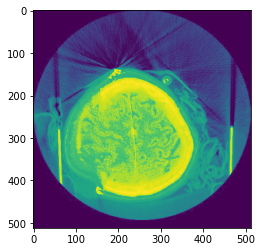

In [368]:
plt.imshow(X[1][:,:,2])

In [314]:
min_value = np.min(X)
max_value = np.max(X)

print("minimum pixel value:", min_value)
print("maximum pixel value:", max_value)

minimum pixel value: 0.0
maximum pixel value: 1.0


In [371]:
998 # idk how we can get rid

998

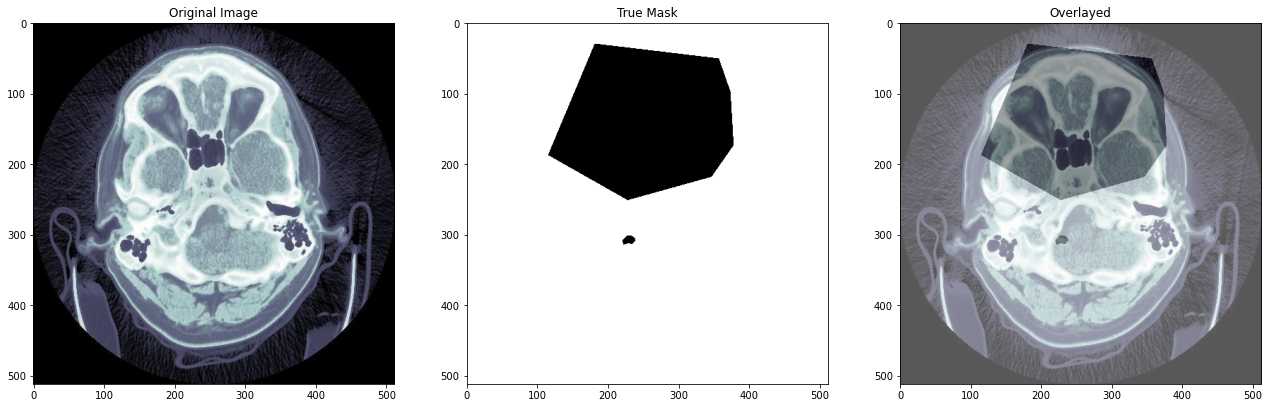

In [394]:
index = np.random.randint(len(X_train))

image = X_train[index]
true_mask = y_train[index]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

axes[0].imshow(image)
axes[0].set_title("Original Image")

axes[1].imshow(true_mask.squeeze(), cmap='gray')
axes[1].set_title("True Mask")

axes[2].imshow(image)
axes[2].imshow(true_mask.squeeze(), cmap='gray', alpha=0.35)
axes[2].set_title("Overlayed")

plt.show()

In [376]:
print(f'number of samples: {len(X)}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

number of samples: 1327
X_train shape: (1194, 512, 512, 3)
y_train shape: (1194, 512, 512, 1)
X_val shape: (133, 512, 512, 3)
y_val shape: (133, 512, 512, 1)


In [379]:
def conv_block(inputs, filters, bn = True):
    conv = Conv2D(filters, (3, 3), padding='same')(inputs)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(filters, (3, 3), padding='same')(conv)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

def unet(input_size=(img_height, img_width, 3), num_filters=8):
    inputs = Input(input_size)

    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, num_filters*2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, num_filters*4)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, num_filters*8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, num_filters*16)

    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, num_filters*8)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, num_filters*4)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, num_filters*2)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, num_filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=inputs, outputs=outputs)

In [380]:
model = unet()
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 512, 512, 8)  224         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 512, 512, 8)  32          conv2d_243[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 512, 512, 8)  0           batch_normalization_144[0][0]    
___________________________________________________________________________________________

In [381]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train the model and compare the true mask to the predicted mask. Noting any accuracy metrics
checkpoint = ModelCheckpoint('unet_weights.h5', monitor='val_loss', save_best_only=True)

epochs = 2
batch_size = 6

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=(X_val, y_val))

Epoch 1/2
199/199 [==============================] - 25s 126ms/step - loss: 0.4704 - accuracy: 0.7288 - val_loss: 0.5007 - val_accuracy: 0.9210
Epoch 2/2
199/199 [==============================] - 24s 123ms/step - loss: 0.3615 - accuracy: 0.9519 - val_loss: 0.3680 - val_accuracy: 0.9735


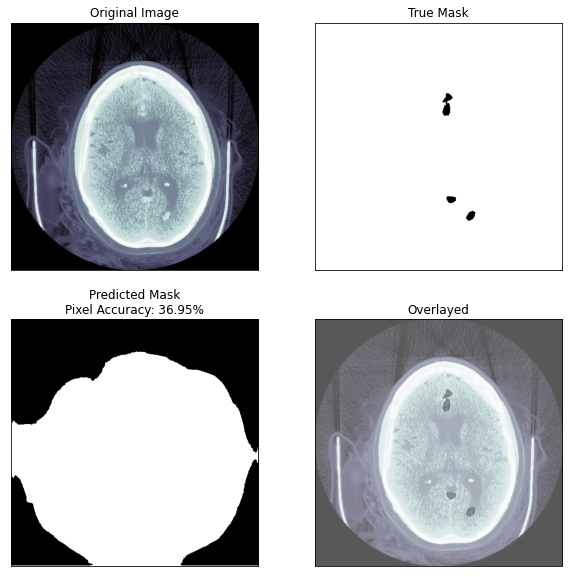

In [386]:
index = np.random.randint(len(X_val))
image = X_val[index]
true_mask = y_val[index]
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
predicted_mask = (predicted_mask < 0.4).astype(np.uint8)
pixel_accuracy = (predicted_mask == true_mask.squeeze()).mean()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")

axes[0, 1].imshow(true_mask.squeeze(), cmap='gray')
axes[0, 1].set_title("True Mask")

axes[1, 0].imshow(predicted_mask.squeeze(), cmap='gray')
axes[1, 0].set_title("Predicted Mask\nPixel Accuracy: {:.2f}%".format(pixel_accuracy*100))

axes[1, 1].imshow(image)
axes[1, 1].imshow(true_mask.squeeze(), cmap='gray', alpha=0.35)
axes[1, 1].set_title("Overlayed")

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()